In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Contamination evolution as a function of loop
Because of low number of some contaminants, percentages of contamination may be misleading... we try to address this further in the analysis by taking into account counts of light-curves

In [2]:
# load test set
test_for_loop = pd.read_csv('../data/initial_state/UncSampling/test_samples/test_after_loop.csv', 
                                           index_col=False)

# select subset of test: only SNe
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]
test_sample = test_for_loop[['objectId','type']]

In [3]:
test_sample['type'].unique()

array(['Ia', 'SNII', 'SLSN-I', 'SNIIP', 'SNIIn', 'SLSN-II', 'SNIc',
       'SNIb', 'SNIIb', 'SNI', 'SN', 'SNIb-pec', 'SNIc-BL', 'SNII-pec',
       'SNIbn'], dtype=object)

In [4]:
family_types = {
    'SNI':['SNIc','SNIb', 'SNI', 'SN', 'SNIb-pec', 'SNIc-BL','SNIbn'],
    'SNIa':['Ia'],
    'SNII':['SNII','SNIIP', 'SNIIn','SNIIb','SNII-pec'],
    'SLSN':['SLSN-I','SLSN-II'],}

def get_family(x, family_types):
    for k in family_types.keys():
        if x in family_types[k]:
            return k
    return 'unknown'

test_sample['type families'] = test_sample['type'].apply(lambda x: get_family(x, family_types))

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_32153/3326250788.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['type families'] = test_sample['type'].apply(lambda x: get_family(x, family_types))


In [5]:
test_sample

,objectId,type,type families
5,1518446800515015003,Ia,SNIa
10,1149301095515015024,Ia,SNIa
13,1399479533215010006,Ia,SNIa
23,1286206560215010001,Ia,SNIa
63,1539182345615015009,Ia,SNIa
...,...,...,...
23663,1434517732715015002,Ia,SNIa
23664,1518189571615010004,Ia,SNIa
23722,1399193911615010003,SNII,SNII
23725,1399473785115015014,Ia,SNIa


In [19]:
# load predictions
preds_dic={}
path_dic = {'FINK':'../dump/data_fink/', 'ZTF':'../dump/data_ZTF/', 'TNS':'../dump/data_allTNS/'}
for k in path_dic.keys():
    list_tmp = []
    for l, fil in enumerate(np.sort(glob.glob(f'{path_dic[k]}/*/*/class_prob/test_class_prob.csv'))):
        tmp = pd.read_csv(fil)
        tmp['loop']=np.ones(len(tmp))*l
        tmp['date'] = fil.split('/')[3]
        tmp = pd.merge(tmp, test_sample, on='objectId', how='inner')
        list_tmp.append(tmp)
    preds_dic[k] = pd.concat(list_tmp)

In [20]:
preds_dic['FINK']['prediction'] = preds_dic['FINK']['probIa'].apply(lambda x: 'Ia' if x>0.5 else 'other')

In [21]:
arr_loop = []
arr_type = []
arr_type_detailed = []
arr_perc = []
arr_count = []
arr_date=[]
for l in preds_dic['FINK']['loop'].unique():
    for typ in preds_dic['FINK']['type families'].unique():
        sel = preds_dic['FINK'][(preds_dic['FINK']['type families']==typ) & (preds_dic['FINK']['loop']==l)]
        alltype = len(sel)
        howmanyasIa = len(sel[sel['prediction']=='Ia'])
        percentage = howmanyasIa/alltype*100
        arr_loop.append(l)
        arr_type.append(typ)
        arr_perc.append(round(percentage,2))
        arr_count.append(howmanyasIa)
        arr_date.append(sel['date'].iloc[0])
df_contamination = pd.DataFrame({'loop':arr_loop,'type families':arr_type, 'percentage':arr_perc, '# as Ia':arr_count, 'date':arr_date})

Text(0, 0.5, 'contamination / efficiency (%)')

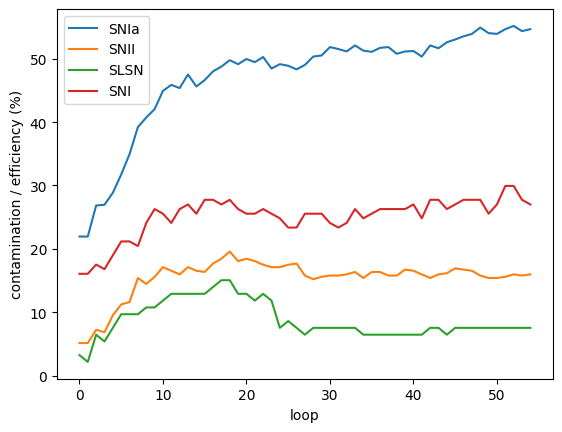

In [22]:
for typ in df_contamination['type families'].unique():
    sel = df_contamination[df_contamination['type families']==typ]
    plt.plot(sel['loop'], sel['percentage'], label=typ)
plt.legend()
plt.xlabel('loop')
plt.ylabel('contamination / efficiency (%)')

In [23]:
arr_loop = []
arr_type = []
arr_type_detailed = []
arr_perc = []
arr_count = []
arr_date=[]
arr_family=[]
for l in preds_dic['FINK']['loop'].unique():
    for typ in preds_dic['FINK']['type'].unique():
        sel = preds_dic['FINK'][(preds_dic['FINK']['type']==typ) & (preds_dic['FINK']['loop']==l)]
        alltype = len(sel)
        howmanyasIa = len(sel[sel['prediction']=='Ia'])
        percentage = howmanyasIa/alltype*100
        arr_loop.append(l)
        arr_type.append(typ)
        arr_family.append(get_family(typ, family_types))
        arr_perc.append(round(percentage,2))
        arr_count.append(howmanyasIa)
        arr_date.append(sel['date'].iloc[0])
df_contamination_subtypes = pd.DataFrame({'loop':arr_loop,'type':arr_type, 'percentage':arr_perc, '# as Ia':arr_count, 'date':arr_date, 'type families':arr_family})

Text(0.5, 1.0, 'SN I')

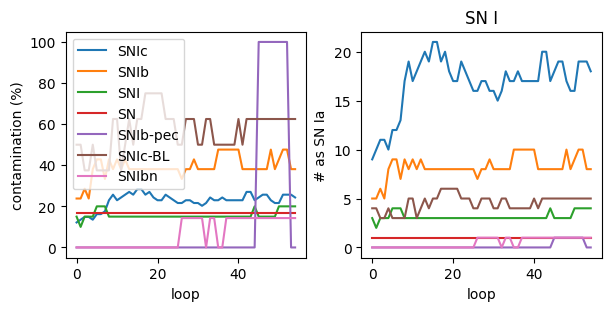

In [24]:
# Ibc 
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 2)
axs = gs.subplots(sharex=False, sharey=False)
tmp = df_contamination_subtypes[df_contamination_subtypes['type families']=='SNI']
for typ in tmp['type'].unique():
    sel = tmp[tmp['type']==typ]
    axs[0].plot(sel['loop'], sel['percentage'], label=typ)
    axs[0].set_xlabel('loop')
    axs[0].set_ylabel('contamination (%)')
    axs[1].plot(sel['loop'], sel['# as Ia'], label=typ)
    axs[1].set_xlabel('loop')
    axs[1].set_ylabel('# as SN Ia')
axs[0].legend()
plt.title('SN I')

Text(0.5, 1.0, 'SN Ic')

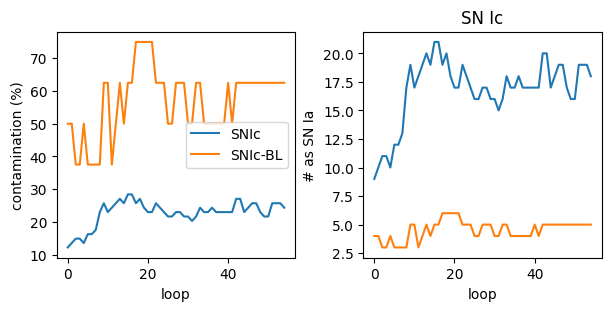

In [25]:
# Ibc 
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 2)
axs = gs.subplots(sharex=False, sharey=False)
tmp = df_contamination_subtypes[df_contamination_subtypes['type families']=='SNI']
for typ in ['SNIc','SNIc-BL']:
    sel = tmp[tmp['type']==typ]
    axs[0].plot(sel['loop'], sel['percentage'], label=typ)
    axs[0].set_xlabel('loop')
    axs[0].set_ylabel('contamination (%)')
    axs[1].plot(sel['loop'], sel['# as Ia'], label=typ)
    axs[1].set_xlabel('loop')
    axs[1].set_ylabel('# as SN Ia')
axs[0].legend()
plt.title('SN Ic')

Text(0.5, 1.0, 'SN II')

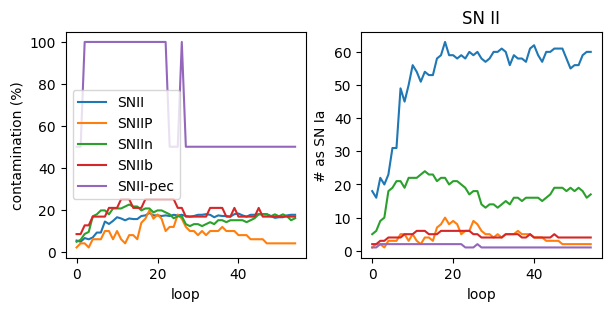

In [26]:
# II 
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 2)
axs = gs.subplots(sharex=False, sharey=False)
tmp = df_contamination_subtypes[df_contamination_subtypes['type families']=='SNII']
for typ in tmp['type'].unique():
    sel = tmp[tmp['type']==typ]
    axs[0].plot(sel['loop'], sel['percentage'], label=typ)
    axs[0].set_xlabel('loop')
    axs[0].set_ylabel('contamination (%)')
    axs[1].plot(sel['loop'], sel['# as Ia'], label=typ)
    axs[1].set_xlabel('loop')
    axs[1].set_ylabel('# as SN Ia')
axs[0].legend()
plt.title('SN II')

Text(0.5, 1.0, 'SLSN')

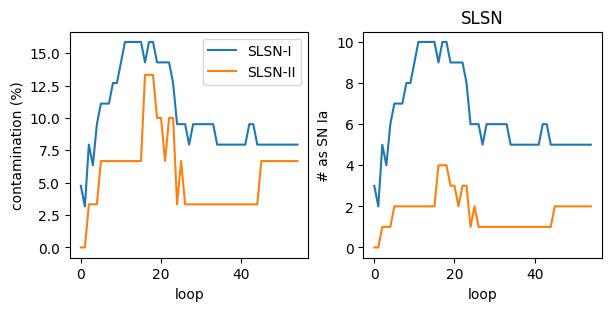

In [27]:
# SLSN 
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 2)
axs = gs.subplots(sharex=False, sharey=False)
tmp = df_contamination_subtypes[df_contamination_subtypes['type families']=='SLSN']
for typ in tmp['type'].unique():
    sel = tmp[tmp['type']==typ]
    axs[0].plot(sel['loop'], sel['percentage'], label=typ)
    axs[0].set_xlabel('loop')
    axs[0].set_ylabel('contamination (%)')
    axs[1].plot(sel['loop'], sel['# as Ia'], label=typ)
    axs[1].set_xlabel('loop')
    axs[1].set_ylabel('# as SN Ia')
axs[0].legend()
plt.title('SLSN')